In [8]:
import detectevent
from detectevent import DetectEvent
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
%matplotlib ipympl
from scipy.integrate import simpson
from scipy.signal import savgol_filter

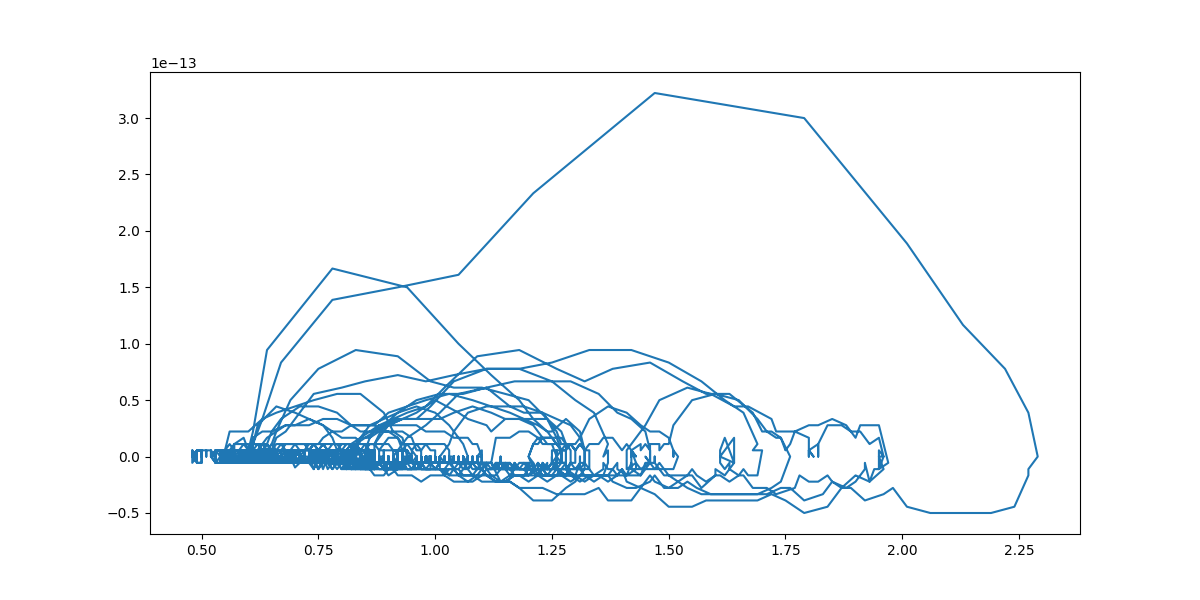

In [148]:
df = pd.read_csv('usgs-data/01302020_shorter2.csv') # read in data
df = df.rename(columns={'00065': 'height', 'datetime': 'time'}) # rename columns

df['time'] = pd.to_datetime(df['time'], format="%Y-%m-%d %H:%M:%S%z") # convert time from strings to datetime

# smooth original data
# df['height'] = df['height'].rolling(10, center=True).mean()
# df['height'] = savgol_filter(df['height'], window_length=11, polyorder=2)

# method 1 compute the derivative dh/dt
df['time_num'] = df['time'].astype(np.int64)
df['dh_dt'] = np.gradient(df['height'], df['time_num'])

# smoothing dh/dt
# df['dh_dt'] = savgol_filter(df['dh_dt'], window_length=11, polyorder=2)

# plot the hysteresis
plt.figure(figsize=(12, 6))
plt.plot(df['height'], df['dh_dt'])
# plt.plot(df['time'], df['height'])

In [140]:
# Ensure time is datetime and calculate dh/dt
# df['time'] = pd.to_datetime(df['time'])
# df['dh_dt'] = np.gradient(df['height'])  # Assumes uniform time intervals

# Detect sign changes in derivative (peaks/troughs)
df['rising'] = df['dh_dt'] > 0
sign_changes = np.where(df['rising'].diff().fillna(False))[0]

# Group into events (rising + falling phases)
events = []
for i in range(0, len(sign_changes)-1, 2):
    start_idx = sign_changes[i]
    end_idx = sign_changes[i+1] if i+1 < len(sign_changes) else len(df)-1

    events.append({
        'start_time': df.iloc[start_idx]['time'],
        'end_time': df.iloc[end_idx]['time'],
        'peak_time': df.iloc[start_idx:end_idx+1]['height'].idxmax(),
        'max_height': df.iloc[start_idx:end_idx+1]['height'].max()
    })

events_df = pd.DataFrame(events)

/var/folders/pq/w466krps4015y7cfwg_sl2_40000gn/T/ipykernel_4946/1697142607.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sign_changes = np.where(df['rising'].diff().fillna(False))[0]


In [115]:
df = pd.read_csv('usgs-data/01302020_shorter2.csv')  # read in data
df = df.rename(columns={'00065': 'height', 'datetime': 'time'})  # rename columns
df['time'] = pd.to_datetime(df['time'], format="%Y-%m-%d %H:%M:%S%z")  # convert time from strings to datetime

# Method 1: compute the derivative dh/dt
df['time_num'] = df['time'].astype(np.int64)
df['dh_dt'] = np.gradient(df['height'], df['time_num'])

df['height'] = savgol_filter(df['height'], window_length=24, polyorder=2)

# Smoothing dh/dt
df['dh_dt'] = savgol_filter(df['dh_dt'], window_length=24, polyorder=2)
df['rising'] = df['dh_dt'] > 0

# Find all sign changes (both rising→falling and falling→rising)
sign_changes = np.where(df['rising'].diff().fillna(False) != 0)[0]

# Group into events (complete cycles)
events = []
# We need at least 2 sign changes to define an event
if len(sign_changes) >= 2:
    # Check if the first segment is rising or falling
    first_is_rising = df.iloc[sign_changes[0]]['rising']

    # Adjust the starting index if needed
    start_idx = 0
    if not first_is_rising:
        # If first segment is falling, it's the end of a previous event
        # Start with the next rising segment
        if len(sign_changes) > 1:
            start_idx = 1

    # Process complete events (rising + falling phases)
    for i in range(start_idx, len(sign_changes)-1, 2):
        if i+1 < len(sign_changes):
            # Start with a rising segment
            rising_start_idx = sign_changes[i]

            # The next sign change is where it starts falling
            falling_start_idx = sign_changes[i+1]

            # If there's another sign change, that's the end of falling
            falling_end_idx = sign_changes[i+2] if i+2 < len(sign_changes) else len(df)-1

            # Extract event data
            event_segment = df.iloc[rising_start_idx:falling_end_idx+1]

            # Find the peak (maximum height during the event)
            peak_idx = event_segment['height'].idxmax()
            peak_time = df.loc[peak_idx, 'time']
            max_height = df.loc[peak_idx, 'height']

            events.append({
                'start_time': df.iloc[rising_start_idx]['time'],
                'end_time': df.iloc[falling_end_idx]['time'],
                'peak_time': peak_time,
                'max_height': max_height,
                'rising_duration': df.iloc[falling_start_idx]['time'] - df.iloc[rising_start_idx]['time'],
                'falling_duration': df.iloc[falling_end_idx]['time'] - df.iloc[falling_start_idx]['time']
            })

events_df = pd.DataFrame(events)


/var/folders/pq/w466krps4015y7cfwg_sl2_40000gn/T/ipykernel_4946/4046657310.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sign_changes = np.where(df['rising'].diff().fillna(False) != 0)[0]


In [141]:
min_duration = pd.Timedelta('90m')  # 1 hour minimum
events_df = events_df[events_df['end_time'] - events_df['start_time'] >= min_duration]

In [142]:
len(events_df)

96

In [165]:
def merge_close_events(events_df, max_gap='1h'):
    if len(events_df) == 0:
        return events_df

    # Convert max_gap to Timedelta if it's a string
    max_gap = pd.Timedelta(max_gap)

    # Sort by start time
    events_df = events_df.sort_values('start_time').reset_index(drop=True)

    merged_events = []
    current_event = events_df.iloc[0].copy()  # Initialize with the first event

    for _, next_event in events_df.iloc[1:].iterrows():
        gap = next_event['start_time'] - current_event['end_time']

        # If gap <= max_gap, merge into current_event
        if gap <= max_gap:
            current_event['end_time'] = next_event['end_time']
            current_event['max_height'] = max(current_event['max_height'], next_event['max_height'])
            # Update peak_time to the time of the higher peak
            if next_event['max_height'] > current_event['max_height']:
                current_event['peak_time'] = next_event['peak_time']
        else:
            merged_events.append(current_event)
            current_event = next_event.copy()

    # Add the last event
    merged_events.append(current_event)

    return pd.DataFrame(merged_events)

# Example usage
events_df = merge_close_events(events_df, max_gap='5h')

In [143]:
def dynamic_merge(events_df, base_gap='1H', height_factor=0.1):
    events_df = events_df.sort_values('start_time')
    merged_events = []
    current_event = events_df.iloc[0].copy()

    for _, next_event in events_df.iloc[1:].iterrows():
        # Scale gap tolerance with event height (larger events = wider merge window)
        dynamic_gap = pd.Timedelta(base_gap) * (1 + height_factor * current_event['max_height'])
        gap = next_event['start_time'] - current_event['end_time']

        if gap <= dynamic_gap:
            current_event['end_time'] = next_event['end_time']
            current_event['max_height'] = max(current_event['max_height'], next_event['max_height'])
        else:
            merged_events.append(current_event)
            current_event = next_event.copy()

    merged_events.append(current_event)
    return pd.DataFrame(merged_events)

events_df = dynamic_merge(events_df, base_gap='5h')

In [145]:
def calculate_loop_area(event_row):
    """Calculate hysteresis loop area for a single event."""
    # Extract event data
    mask = (df['time'] >= event_row['start_time']) & (df['time'] <= event_row['end_time'])
    event_data = df.loc[mask]

    # Split into rising/falling phases
    rising = event_data[event_data['dh_dt'] > 0]
    falling = event_data[event_data['dh_dt'] < 0]

    # Check minimum points requirement (at least 3 points for simpson)
    if len(rising) < 3 or len(falling) < 3:
        return 0.0  # Return 0 for invalid segments

    # Sort by height for proper integration
    rising = rising.sort_values('height')
    falling = falling.sort_values('height')

    try:
        # Calculate absolute loop area
        area = abs(
            simpson(rising['dh_dt'].values, rising['height'].values) -
            simpson(falling['dh_dt'].values, falling['height'].values)
        )
        return area
    except:
        return 0.0

# Apply with error handling
events_df['loop_area'] = events_df.apply(calculate_loop_area, axis=1)

# Filter events (keep top 50% by area)
min_area = events_df['loop_area'].quantile(0.000001)
events_df = events_df[events_df['loop_area'] > min_area].copy()

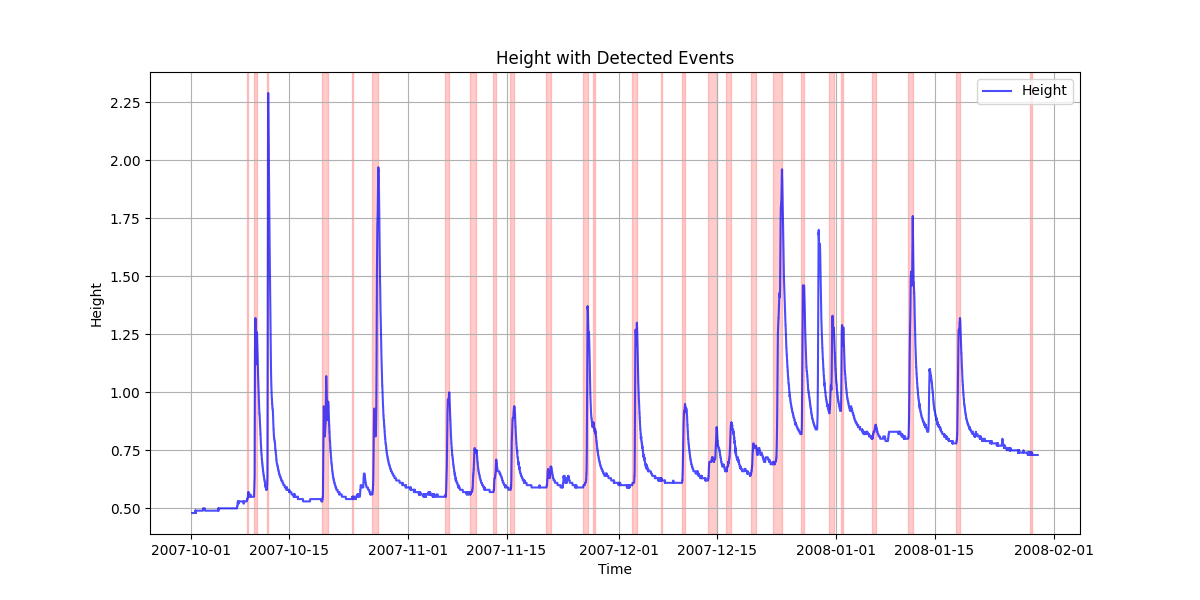

In [146]:


plt.figure(figsize=(12, 6))

# Plot raw data
plt.plot(df['time'], df['height'], 'b-', label='Height', alpha=0.7)
# plt.plot(df['time'], df['height_smooth'], 'k-', label='Height', alpha=0.7)

# Highlight events
for _, event in events_df.iterrows():
    plt.axvspan(event['start_time'], event['end_time'],
               color='red', alpha=0.2, label='Event' if _ == 0 else "")
    # plt.scatter(event['peak_time'], event['max_height'],
    #            color='black', s=50, zorder=5)




# Rolling 95th percentile of dh/dt (adaptive to seasonal changes)
# df['rise_threshold'] = df['dh_dt'].rolling(7).quantile(0.95)
# flood_events = df[df['dh_dt'] > df['rise_threshold']]

# Dynamic threshold (top 5% of positive rates)
# threshold = df['dh_dt'].quantile(0.90)
# floods = df[(df['dh_dt'] > threshold) & (df['height'] > df['height'].quantile(0.35))]

# plt.plot(df['time'], df['height'], label='Height')
# plt.scatter(floods['time'], floods['height'], color='red', label='Flood Events')
# plt.scatter(flood_events['time'], flood_events['height'], color='red', label='Flood Events')


plt.xlabel('Time')
plt.ylabel('Height')
plt.title('Height with Detected Events')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import ndimage
from datetime import timedelta

def detect_events_phase_space(data, height_col='gage_height', time_col='datetime',
                             smoothing_window=24, threshold=0.1, min_duration=6):
    """
    Detect hydrological events using phase space analysis (derivative vs height)

    Parameters:
    -----------
    data : pandas DataFrame
        DataFrame containing the gage height time series
    height_col : str
        Column name for gage height data
    time_col : str
        Column name for datetime data
    smoothing_window : int
        Window size for smoothing the data (in hours)
    threshold : float
        Threshold for derivative to be considered significant
    min_duration : int
        Minimum duration for an event in hours

    Returns:
    --------
    events : list of tuples
        List of (start_time, end_time) for each detected event
    """
    # Ensure data is sorted by time
    data = data.sort_values(by=time_col)

    # Convert to numeric if needed and handle missing values
    heights = pd.to_numeric(data[height_col], errors='coerce')
    heights = heights.interpolate()

    # Apply smoothing to reduce noise
    heights_smooth = ndimage.gaussian_filter1d(heights, sigma=smoothing_window/4)

    # Calculate derivative (rate of change)
    # Using simple difference with appropriate time scaling
    time_diff = np.diff(data[time_col].astype(np.int64)) / 1e9 / 3600  # Convert to hours
    height_diff = np.diff(heights_smooth)
    derivative = height_diff / time_diff

    # Add a 0 at the end to match length of original data
    derivative = np.append(derivative, 0)

    # Find where derivative exceeds threshold (both positive and negative)
    significant_changes = np.abs(derivative) > threshold

    # Find contiguous regions of significant changes
    labeled_regions, num_regions = ndimage.label(significant_changes)

    # Extract events
    events = []
    for i in range(1, num_regions + 1):
        event_indices = np.where(labeled_regions == i)[0]

        if len(event_indices) >= min_duration:  # Only keep events longer than min_duration
            start_idx = event_indices[0]
            end_idx = event_indices[-1]

            start_time = data[time_col].iloc[start_idx]
            end_time = data[time_col].iloc[end_idx]

            events.append((start_time, end_time))

    # For visualization purposes, create a phase plot
    plt.figure(figsize=(10, 6))
    plt.scatter(heights_smooth[:-1], derivative[:-1], alpha=0.5, s=3)

    # Highlight events
    for start, end in events:
        start_idx = data[data[time_col] == start].index[0]
        end_idx = data[data[time_col] == end].index[0]

        event_heights = heights_smooth[start_idx:end_idx+1]
        event_derivs = derivative[start_idx:end_idx+1]

        plt.plot(event_heights, event_derivs, 'r-', linewidth=2)

    plt.xlabel('Gage Height')
    plt.ylabel('Rate of Change (derivative)')
    plt.title('Phase Space Analysis for Event Detection')
    plt.grid(True)
    plt.savefig('phase_space_events.png')

    return events

detect_events_phase_space(df, 'height', 'time')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import ndimage
from datetime import timedelta
import matplotlib.dates as mdates

def detect_events_phase_space(data, height_col='gage_height', time_col='datetime',
                             smoothing_window=9, threshold=0.03, min_duration=5):
    """
    Detect hydrological events using phase space analysis (derivative vs height)
    and display them on a time series plot

    Parameters:
    -----------
    data : pandas DataFrame
        DataFrame containing the gage height time series
    height_col : str
        Column name for gage height data
    time_col : str
        Column name for datetime data
    smoothing_window : int
        Window size for smoothing the data (in hours)
    threshold : float
        Threshold for derivative to be considered significant
    min_duration : int
        Minimum duration for an event in hours

    Returns:
    --------
    events : list of tuples
        List of (start_time, end_time) for each detected event
    """
    # Ensure data is sorted by time
    data = data.sort_values(by=time_col)

    # Convert to numeric if needed and handle missing values
    heights = pd.to_numeric(data[height_col], errors='coerce')
    heights = heights.interpolate()

    # Apply smoothing to reduce noise
    heights_smooth = ndimage.gaussian_filter1d(heights, sigma=smoothing_window/4)

    # Calculate derivative (rate of change)
    # Using simple difference with appropriate time scaling
    time_diff = np.diff(data[time_col].astype(np.int64)) / 1e9 / 3600  # Convert to hours
    height_diff = np.diff(heights_smooth)
    derivative = height_diff / time_diff

    # Add a 0 at the end to match length of original data
    derivative = np.append(derivative, 0)

    # Find where derivative exceeds threshold (both positive and negative)
    significant_changes = np.abs(derivative) > threshold

    # Find contiguous regions of significant changes
    labeled_regions, num_regions = ndimage.label(significant_changes)

    # Extract events
    events = []
    for i in range(1, num_regions + 1):
        event_indices = np.where(labeled_regions == i)[0]

        if len(event_indices) >= min_duration:  # Only keep events longer than min_duration
            start_idx = event_indices[0]
            end_idx = event_indices[-1]

            start_time = data[time_col].iloc[start_idx]
            end_time = data[time_col].iloc[end_idx]

            events.append((start_time, end_time))

    # Create a time series plot with highlighted events
    plt.figure(figsize=(12, 6))

    # Plot height vs time
    plt.plot(data[time_col], heights_smooth, 'b-', linewidth=1.5, label='Smoothed Gage Height')
    plt.plot(data[time_col], heights, 'c-', alpha=0.5, linewidth=0.5, label='Raw Gage Height')

    # Highlight the events using axvspan
    colors = ['#ffcccc', '#ccffcc', '#ccccff', '#ffffcc', '#ffccff', '#ccffff']  # Different colors for events

    for idx, (start, end) in enumerate(events):
        # color = colors[idx % len(colors)]  # Cycle through colors for different events
        plt.axvspan(start, end, alpha=0.3, color='r',
                   label=f'Event {idx+1}' if idx < 10 else None)  # Only show first 10 in legend

        # Mark start and end points
        # start_height = heights_smooth[data[data[time_col] == start].index[0]]
        # end_height = heights_smooth[data[data[time_col] == end].index[0]]

        # plt.scatter(start, start_height, color='red', s=50, zorder=5)
        # plt.scatter(end, end_height, color='black', s=50, zorder=5)

    # Format the x-axis to show dates nicely
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()  # Rotate date labels

    plt.xlabel('Time')
    plt.ylabel(f'{height_col} (units)')
    plt.title('Water Level Events Detection')
    plt.grid(True, alpha=0.3)

    # Add a legend but keep it manageable
    # if len(events) > 10:
    #     plt.legend(['Smoothed Gage Height', 'Raw Gage Height', 'Events (first 10 shown)'])
    # else:
    #     plt.legend()

    plt.tight_layout()
    plt.savefig('water_level_events.png')
    plt.show()

    return events

events = detect_events_phase_space(df, 'height', 'time')
print(len(events))

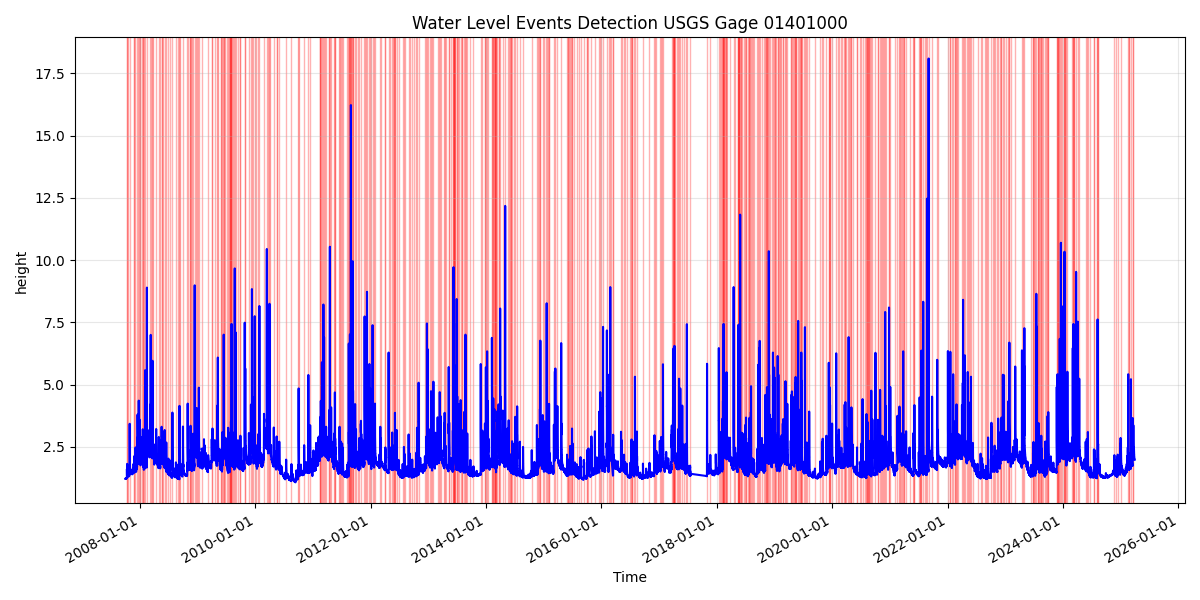

567


In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import ndimage
from datetime import timedelta
import matplotlib.dates as mdates

def detect_events_phase_space(data, height_col='gage_height', time_col='datetime',
                             smoothing_window=24, threshold=0.1, min_duration=6,
                             merge_threshold=24):
    """
    Detect hydrological events using phase space analysis (derivative vs height)
    and display them on a time series plot

    Parameters:
    -----------
    data : pandas DataFrame
        DataFrame containing the gage height time series
    height_col : str
        Column name for gage height data
    time_col : str
        Column name for datetime data
    smoothing_window : int
        Window size for smoothing the data (in hours)
    threshold : float
        Threshold for derivative to be considered significant
    min_duration : int
        Minimum duration for an event in hours
    merge_threshold : int
        Time threshold (in hours) to merge nearby events

    Returns:
    --------
    events : list of tuples
        List of (start_time, end_time) for each detected event
    """
    # Ensure data is sorted by time
    data = data.sort_values(by=time_col)

    # Convert to numeric if needed and handle missing values
    heights = pd.to_numeric(data[height_col], errors='coerce')
    heights = heights.interpolate()

    # Apply smoothing to reduce noise
    heights_smooth = ndimage.gaussian_filter1d(heights, sigma=smoothing_window/4)

    # Calculate derivative (rate of change)
    # Using simple difference with appropriate time scaling
    time_diff = np.diff(data[time_col].astype(np.int64)) / 1e9 / 3600  # Convert to hours
    height_diff = np.diff(heights_smooth)
    derivative = height_diff / time_diff

    # Add a 0 at the end to match length of original data
    derivative = np.append(derivative, 0)

    # Find where derivative exceeds threshold (both positive and negative)
    significant_changes = np.abs(derivative) > threshold

    # Find contiguous regions of significant changes
    labeled_regions, num_regions = ndimage.label(significant_changes)

    # Extract events
    raw_events = []
    for i in range(1, num_regions + 1):
        event_indices = np.where(labeled_regions == i)[0]

        if len(event_indices) >= min_duration:  # Only keep events longer than min_duration
            start_idx = event_indices[0]
            end_idx = event_indices[-1]

            start_time = data[time_col].iloc[start_idx]
            end_time = data[time_col].iloc[end_idx]

            raw_events.append((start_time, end_time))

    # Merge events that are too close to each other
    if not raw_events:
        events = []
    else:
        # Sort events by start time
        raw_events.sort(key=lambda x: x[0])

        # Initialize merged events with the first event
        events = [raw_events[0]]

        # Merge subsequent events if they're close enough
        for current_start, current_end in raw_events[1:]:
            prev_start, prev_end = events[-1]

            # Calculate time difference between previous event end and current event start
            time_between = (current_start - prev_end).total_seconds() / 3600  # in hours

            if time_between <= merge_threshold:
                # Merge with previous event
                events[-1] = (prev_start, max(current_end, prev_end))
            else:
                # Add as a new event
                events.append((current_start, current_end))

    # Create a time series plot with highlighted events
    plt.figure(figsize=(12, 6))

    # Plot height vs time
    # plt.plot(data[time_col], heights_smooth, 'b-', linewidth=1.5, label='Smoothed Gage Height')
    # plt.plot(data[time_col], heights, 'c-', alpha=0.5, linewidth=0.5, label='Raw Gage Height')
    plt.plot(data[time_col], heights, 'b-', alpha=1, linewidth=1.5, label='Raw Gage Height')


    # Highlight the events using axvspan
    # colors = ['#ffcccc', '#ccffcc', '#ccccff', '#ffffcc', '#ffccff', '#ccffff']  # Different colors for events

    for idx, (start, end) in enumerate(events):
        # color = colors[idx % len(colors)]  # Cycle through colors for different events
        plt.axvspan(start, end, alpha=0.3, color='r',
                   label=f'Event {idx+1}' if idx < 10 else None)  # Only show first 10 in legend

        # Mark start and end points
        # start_height = heights_smooth[data[data[time_col] == start].index[0]]
        # end_height = heights_smooth[data[data[time_col] == end].index[0]]

        # plt.scatter(start, start_height, color='red', s=50, zorder=5)
        # plt.scatter(end, end_height, color='black', s=50, zorder=5)

    # Format the x-axis to show dates nicely
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()  # Rotate date labels

    plt.xlabel('Time')
    plt.ylabel(f'{height_col}')
    plt.title('Water Level Events Detection USGS Gage 01401000')
    plt.grid(True, alpha=0.3)

    # Add a legend but keep it manageable
    # if len(events) > 10:
    #     plt.legend(['Smoothed Gage Height', 'Raw Gage Height', 'Events (first 10 shown)'])
    # else:
    #     plt.legend()

    plt.tight_layout()
    plt.savefig('water_level_events_merged.png', dpi=300)
    plt.show()

    return events


df = pd.read_csv('usgs-data/01401000.csv') # read in data
df = df.rename(columns={'00065': 'height', 'datetime': 'time'}) # rename columns

df['time'] = pd.to_datetime(df['time'], format="%Y-%m-%d %H:%M:%S%z") # convert time from strings to datetime

events = detect_events_phase_space(df, 'height', 'time', smoothing_window=12, threshold=0.10, min_duration=4, merge_threshold=30)
print(len(events))

mis-counted: 25
not counted: 1

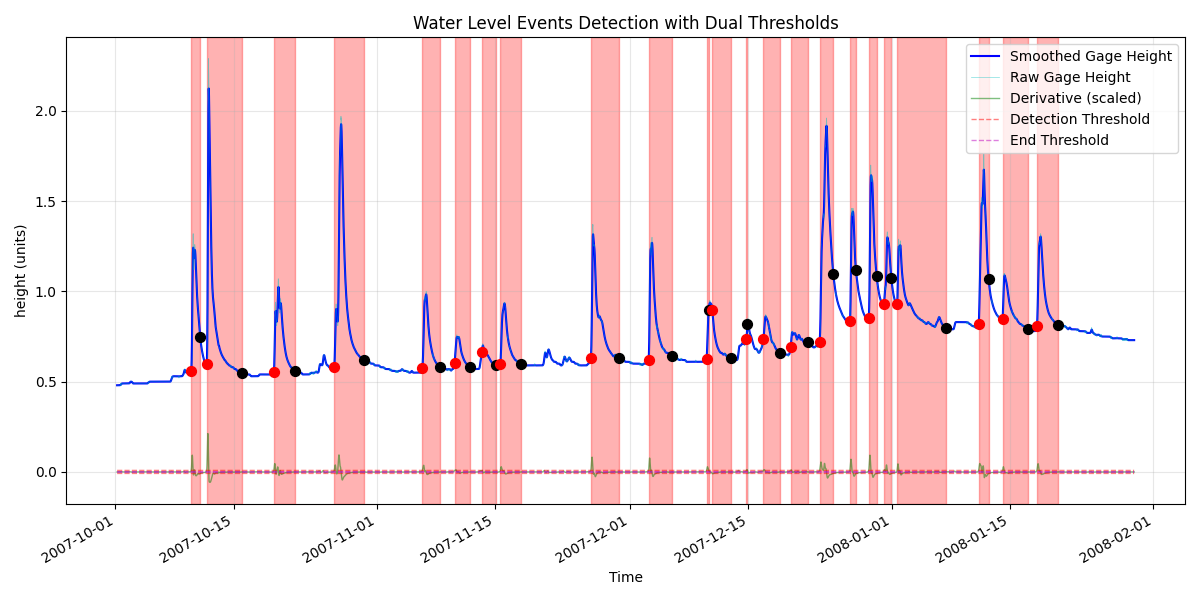

23


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import ndimage
from datetime import timedelta
import matplotlib.dates as mdates

def detect_events_phase_space(data, height_col='gage_height', time_col='datetime',
                             smoothing_window=24, detect_threshold=0.1,
                             end_threshold=0.05, min_duration=6,
                             merge_threshold=24):
    """
    Detect hydrological events using phase space analysis (derivative vs height)
    and display them on a time series plot

    Parameters:
    -----------
    data : pandas DataFrame
        DataFrame containing the gage height time series
    height_col : str
        Column name for gage height data
    time_col : str
        Column name for datetime data
    smoothing_window : int
        Window size for smoothing the data (in hours)
    detect_threshold : float
        Threshold for derivative to be considered significant for event detection
    end_threshold : float
        Lower threshold for derivative to determine when an event truly ends
    min_duration : int
        Minimum duration for an event in hours
    merge_threshold : int
        Time threshold (in hours) to merge nearby events

    Returns:
    --------
    events : list of tuples
        List of (start_time, end_time) for each detected event
    """
    # Ensure data is sorted by time
    data = data.sort_values(by=time_col)

    # Convert to numeric if needed and handle missing values
    heights = pd.to_numeric(data[height_col], errors='coerce')
    heights = heights.interpolate() # fills NaN values using interpolation

    # Apply smoothing to reduce noise
    heights_smooth = ndimage.gaussian_filter1d(heights, sigma=smoothing_window/4)

    # Calculate derivative (rate of change)
    # Using simple difference with appropriate time scaling
    time_diff = np.diff(data[time_col].astype(np.int64)) / 1e9 / 3600  # Convert to hours
    height_diff = np.diff(heights_smooth)
    derivative = height_diff / time_diff

    # Add a 0 at the end to match length of original data
    derivative = np.append(derivative, 0)

    # Find where derivative exceeds detection threshold (both positive and negative)
    significant_changes = np.abs(derivative) > detect_threshold

    # Find contiguous regions of significant changes for initial event detection
    labeled_regions, num_regions = ndimage.label(significant_changes)

    # Extract initial events
    raw_events = []
    for i in range(1, num_regions + 1):
        event_indices = np.where(labeled_regions == i)[0]

        if len(event_indices) >= min_duration:  # Only keep events longer than min_duration
            start_idx = event_indices[0]

            # Instead of ending at the last point where derivative > detect_threshold,
            # we'll extend until derivative < end_threshold
            init_end_idx = event_indices[-1]

            # Look beyond initial end for the true end (where derivative becomes small enough)
            extend_idx = init_end_idx
            for j in range(init_end_idx + 1, len(derivative)):
                if np.abs(derivative[j]) <= end_threshold:
                    extend_idx = j
                    break
                # If derivative increases again above detection threshold, stop extending
                if np.abs(derivative[j]) > detect_threshold:
                    break

            # Use the extended end index
            end_idx = extend_idx

            # Get actual timestamps
            start_time = data[time_col].iloc[start_idx]
            end_time = data[time_col].iloc[end_idx]

            raw_events.append((start_time, end_time))

    # Merge events that are too close to each other
    if not raw_events:
        events = []
    else:
        # Sort events by start time
        raw_events.sort(key=lambda x: x[0])

        # Initialize merged events with the first event
        events = [raw_events[0]]

        # Merge subsequent events if they're close enough
        for current_start, current_end in raw_events[1:]:
            prev_start, prev_end = events[-1]

            # Calculate time difference between previous event end and current event start
            time_between = (current_start - prev_end).total_seconds() / 3600  # in hours

            if time_between <= merge_threshold:
                # Merge with previous event
                events[-1] = (prev_start, max(current_end, prev_end))
            else:
                # Add as a new event
                events.append((current_start, current_end))

    # Create a time series plot with highlighted events
    plt.figure(figsize=(12, 6))

    # Plot height vs time
    plt.plot(data[time_col], heights_smooth, 'b-', linewidth=1.5, label='Smoothed Gage Height')
    plt.plot(data[time_col], heights, 'c-', alpha=0.5, linewidth=0.5, label='Raw Gage Height')

    # Plot derivative (scaled) to show threshold levels
    max_height = heights_smooth.max()
    scaled_derivative = derivative * (max_height / derivative.max() / 10)
    plt.plot(data[time_col], scaled_derivative, 'g-', alpha=0.5, linewidth=1, label='Derivative (scaled)')

    # Add threshold reference lines
    detect_line = np.ones_like(heights_smooth) * (detect_threshold * max_height / derivative.max() / 10)
    end_line = np.ones_like(heights_smooth) * (end_threshold * max_height / derivative.max() / 10)
    plt.plot(data[time_col], detect_line, 'r--', alpha=0.5, linewidth=1, label='Detection Threshold')
    plt.plot(data[time_col], -detect_line, 'r--', alpha=0.5, linewidth=1)
    plt.plot(data[time_col], end_line, 'm--', alpha=0.5, linewidth=1, label='End Threshold')
    plt.plot(data[time_col], -end_line, 'm--', alpha=0.5, linewidth=1)

    # Highlight the events using axvspan
    # colors = ['#ffcccc', '#ccffcc', '#ccccff', '#ffffcc', '#ffccff', '#ccffff']  # Different colors for events

    for idx, (start, end) in enumerate(events):
        # color = colors[idx % len(colors)]  # Cycle through colors for different events
        plt.axvspan(start, end, alpha=0.3, color='r',
                   label=f'Event {idx+1}' if idx < 10 else None)  # Only show first 10 in legend

        # Mark start and end points
        start_idx = data[data[time_col] == start].index[0]
        end_idx = data[data[time_col] == end].index[0]

        start_height = heights_smooth[start_idx]
        end_height = heights_smooth[end_idx]

        plt.scatter(start, start_height, color='red', s=50, zorder=5)
        plt.scatter(end, end_height, color='black', s=50, zorder=5)

    # Format the x-axis to show dates nicely
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()  # Rotate date labels

    plt.xlabel('Time')
    plt.ylabel(f'{height_col} (units)')
    plt.title('Water Level Events Detection with Dual Thresholds')
    plt.grid(True, alpha=0.3)

    # Add a legend but keep it manageable
    if len(events) > 5:
        handles, labels = plt.gca().get_legend_handles_labels()
        # Keep the first 5 handles/labels (data series) and remove event labels
        plt.legend(handles[:5], labels[:5])
    else:
        plt.legend()

    plt.tight_layout()
    plt.savefig('water_level_events_dual_threshold.png')
    plt.show()

    return events


df = pd.read_csv('usgs-data/01302020_shorter2.csv') # read in data
df = df.rename(columns={'00065': 'height', 'datetime': 'time'}) # rename columns

df['time'] = pd.to_datetime(df['time'], format="%Y-%m-%d %H:%M:%S%z") # convert time from strings to datetime

events = detect_events_phase_space(df, 'height', 'time', smoothing_window=18, detect_threshold=0.02, end_threshold=1e-5, min_duration=1, merge_threshold=8)
print(len(events))

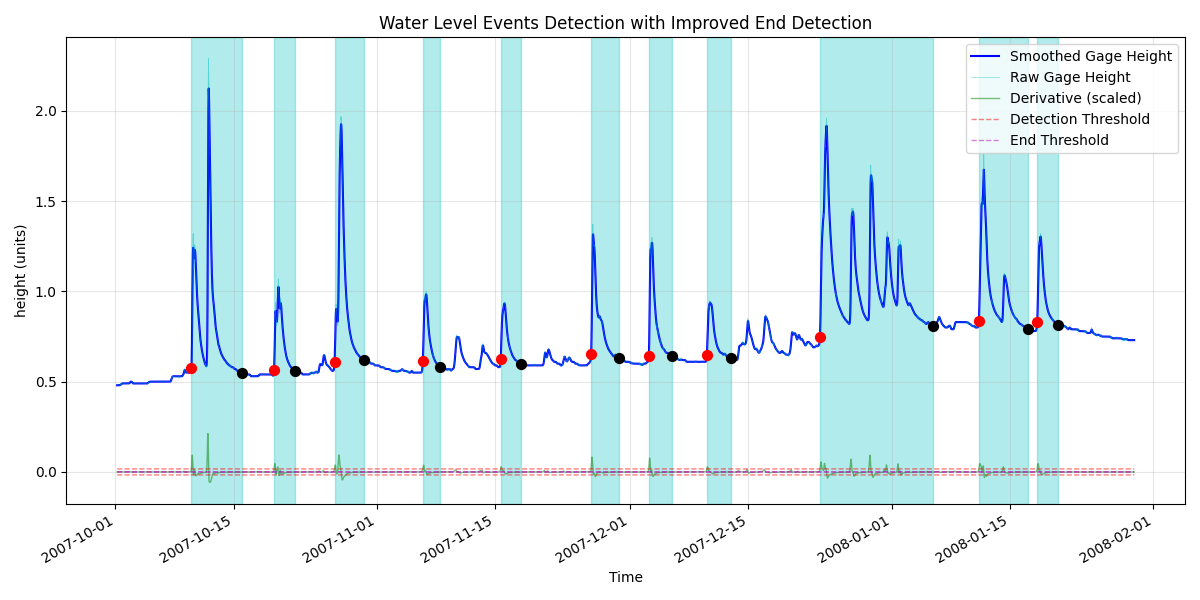

11


In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import ndimage
from datetime import timedelta
import matplotlib.dates as mdates

def detect_events_phase_space(data, height_col='gage_height', time_col='datetime',
                             smoothing_window=24, detect_threshold=0.1,
                             end_threshold=0.05, min_duration=6,
                             merge_threshold=24, extension_window=48):
    """
    Detect hydrological events using phase space analysis (derivative vs height)
    and display them on a time series plot

    Parameters:
    -----------
    data : pandas DataFrame
        DataFrame containing the gage height time series
    height_col : str
        Column name for gage height data
    time_col : str
        Column name for datetime data
    smoothing_window : int
        Window size for smoothing the data (in hours)
    detect_threshold : float
        Threshold for derivative to be considered significant for event detection
    end_threshold : float
        Lower threshold for derivative to determine when an event truly ends
    min_duration : int
        Minimum duration for an event in hours
    merge_threshold : int
        Time threshold (in hours) to merge nearby events
    extension_window : int
        Maximum number of time steps to look ahead for event ending

    Returns:
    --------
    events : list of tuples
        List of (start_time, end_time) for each detected event
    """
    # Ensure data is sorted by time
    data = data.sort_values(by=time_col)

    # Convert to numeric if needed and handle missing values
    heights = pd.to_numeric(data[height_col], errors='coerce')
    heights = heights.interpolate()

    # Apply smoothing to reduce noise
    heights_smooth = ndimage.gaussian_filter1d(heights, sigma=smoothing_window/4)

    # Calculate derivative (rate of change)
    # Using simple difference with appropriate time scaling
    time_diff = np.diff(data[time_col].astype(np.int64)) / 1e9 / 3600  # Convert to hours
    height_diff = np.diff(heights_smooth)
    derivative = height_diff / time_diff

    # Add a 0 at the end to match length of original data
    derivative = np.append(derivative, 0)

    # Find where derivative exceeds detection threshold (both positive and negative)
    significant_changes = np.abs(derivative) > detect_threshold

    # Find contiguous regions of significant changes for initial event detection
    labeled_regions, num_regions = ndimage.label(significant_changes)

    # Extract initial events
    raw_events = []
    for i in range(1, num_regions + 1):
        event_indices = np.where(labeled_regions == i)[0]

        if len(event_indices) >= min_duration:  # Only keep events longer than min_duration
            start_idx = event_indices[0]
            init_end_idx = event_indices[-1]

            # Find the peak within this event
            event_segment = heights_smooth[start_idx:init_end_idx+1]
            peak_offset = np.argmax(event_segment)
            peak_idx = start_idx + peak_offset

            # Now look for the true end of the event
            # We'll search in a window after the peak, not after the initial end
            # This better captures the falling limb
            max_search_idx = min(peak_idx + extension_window, len(derivative) - 1)

            # Initialize with the initial end
            end_idx = init_end_idx

            # Track the minimum derivative value we find
            min_derivative = np.inf
            min_derivative_idx = end_idx

            # Method 1: Find where derivative crosses below end_threshold
            found_end = False
            for j in range(peak_idx + 1, max_search_idx):
                # Keep track of the smallest derivative we find
                if abs(derivative[j]) < min_derivative:
                    min_derivative = abs(derivative[j])
                    min_derivative_idx = j

                # If we find a point below end_threshold, use it
                if abs(derivative[j]) <= end_threshold:
                    end_idx = j
                    found_end = True
                    break

            # If we didn't find a point below end_threshold,
            # use the point with the smallest derivative
            if not found_end and min_derivative_idx > end_idx:
                end_idx = min_derivative_idx

            # Get actual timestamps
            start_time = data[time_col].iloc[start_idx]
            end_time = data[time_col].iloc[end_idx]

            raw_events.append((start_time, end_time))

    # Merge events that are too close to each other
    if not raw_events:
        events = []
    else:
        # Sort events by start time
        raw_events.sort(key=lambda x: x[0])

        # Initialize merged events with the first event
        events = [raw_events[0]]

        # Merge subsequent events if they're close enough
        for current_start, current_end in raw_events[1:]:
            prev_start, prev_end = events[-1]

            # Calculate time difference between previous event end and current event start
            time_between = (current_start - prev_end).total_seconds() / 3600  # in hours

            if time_between <= merge_threshold:
                # Merge with previous event
                events[-1] = (prev_start, max(current_end, prev_end))
            else:
                # Add as a new event
                events.append((current_start, current_end))

    # Create a time series plot with highlighted events
    plt.figure(figsize=(12, 6))

    # Plot height vs time
    plt.plot(data[time_col], heights_smooth, 'b-', linewidth=1.5, label='Smoothed Gage Height')
    plt.plot(data[time_col], heights, 'c-', alpha=0.5, linewidth=0.5, label='Raw Gage Height')

    # Plot derivative (scaled) to show threshold levels
    max_height = heights_smooth.max()
    scaled_derivative = derivative * (max_height / derivative.max() / 10)
    plt.plot(data[time_col], scaled_derivative, 'g-', alpha=0.5, linewidth=1, label='Derivative (scaled)')

    # Add threshold reference lines
    detect_line = np.ones_like(heights_smooth) * (detect_threshold * max_height / derivative.max() / 10)
    end_line = np.ones_like(heights_smooth) * (end_threshold * max_height / derivative.max() / 10)
    plt.plot(data[time_col], detect_line, 'r--', alpha=0.5, linewidth=1, label='Detection Threshold')
    plt.plot(data[time_col], -detect_line, 'r--', alpha=0.5, linewidth=1)
    plt.plot(data[time_col], end_line, 'm--', alpha=0.5, linewidth=1, label='End Threshold')
    plt.plot(data[time_col], -end_line, 'm--', alpha=0.5, linewidth=1)

    # Highlight the events using axvspan
    colors = ['#ffcccc', '#ccffcc', '#ccccff', '#ffffcc', '#ffccff', '#ccffff']  # Different colors for events

    for idx, (start, end) in enumerate(events):
        # color = colors[idx % len(colors)]  # Cycle through colors for different events
        plt.axvspan(start, end, alpha=0.3, color='c',
                   label=f'Event {idx+1}' if idx < 10 else None)  # Only show first 10 in legend

        # Mark start and end points
        start_idx = data[data[time_col] == start].index[0]
        end_idx = data[data[time_col] == end].index[0]

        start_height = heights_smooth[start_idx]
        end_height = heights_smooth[end_idx]

        plt.scatter(start, start_height, color='red', s=50, zorder=5)
        plt.scatter(end, end_height, color='black', s=50, zorder=5)

    # Format the x-axis to show dates nicely
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()  # Rotate date labels

    plt.xlabel('Time')
    plt.ylabel(f'{height_col} (units)')
    plt.title('Water Level Events Detection with Improved End Detection')
    plt.grid(True, alpha=0.3)

    # Add a legend but keep it manageable
    if len(events) > 5:
        handles, labels = plt.gca().get_legend_handles_labels()
        # Keep the first 5 handles/labels (data series) and remove event labels
        plt.legend(handles[:5], labels[:5])
    else:
        plt.legend()

    plt.tight_layout()
    plt.savefig('water_level_events_improved.png')
    plt.show()

    return events

df = pd.read_csv('usgs-data/01302020_shorter2.csv') # read in data
df = df.rename(columns={'00065': 'height', 'datetime': 'time'}) # rename columns

df['time'] = pd.to_datetime(df['time'], format="%Y-%m-%d %H:%M:%S%z") # convert time from strings to datetime

events = detect_events_phase_space(df, 'height', 'time', smoothing_window=18, detect_threshold=0.04, end_threshold=1e-5, min_duration=1, merge_threshold=8, extension_window=500)
print(len(events))

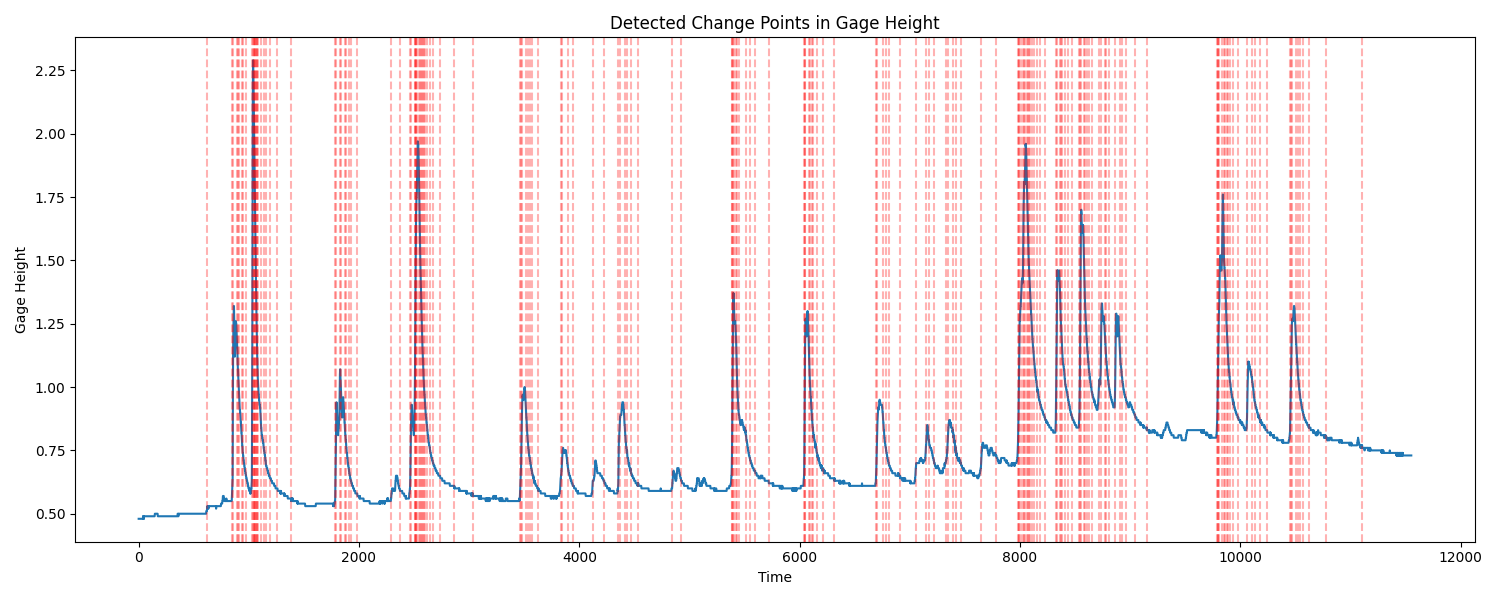

In [105]:
# First, install the library if you haven't already
# pip install ruptures

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ruptures as rpt

# Load your CSV data
def detect_events_with_ruptures(df, column_name='gage_height', date_column='datetime', model="rbf", pen=10):

    # Convert datetime column to pandas datetime if needed
    if date_column in df.columns:
        df[date_column] = pd.to_datetime(df[date_column])

    # Extract the signal (gage height)
    signal = df[column_name].values

    # Apply change point detection
    # Using Pelt algorithm with a robust cost function
    # model = "rbf"  # Radial Basis Function cost  other models: "rbf", "l2", "l1", "normal"
    algo = rpt.Pelt(model=model).fit(signal)

    # Find the optimal number of change points automatically
    # The 'pen' parameter controls the penalty for adding change points
    # Lower values result in more change points
    change_points = algo.predict(pen=pen)

    # Extract the events as segments
    events = []
    for i in range(len(change_points)-1):
        start_idx = change_points[i]
        end_idx = change_points[i+1] - 1

        # Calculate mean and variance to determine if this is an event
        segment = signal[start_idx:end_idx]

        # If using datetime index
        if date_column in df.columns:
            start_time = df[date_column].iloc[start_idx]
            end_time = df[date_column].iloc[min(end_idx, len(df)-1)]

            events.append({
                'start_time': start_time,
                'end_time': end_time,
                'start_idx': start_idx,
                'end_idx': end_idx,
                'mean': np.mean(segment),
                'std': np.std(segment)
            })
        else:
            events.append({
                'start_idx': start_idx,
                'end_idx': end_idx,
                'mean': np.mean(segment),
                'std': np.std(segment)
            })

    # Plot results
    plt.figure(figsize=(15, 6))
    plt.plot(signal)

    # Add vertical lines for change points
    for cp in change_points:
        if cp < len(signal):
            plt.axvline(x=cp, color='r', linestyle='--', alpha=0.3)

    plt.title('Detected Change Points in Gage Height')
    plt.xlabel('Time')
    plt.ylabel('Gage Height')
    plt.tight_layout()
    plt.show()

    return events, change_points


df = pd.read_csv('usgs-data/01302020_shorter2.csv') # read in data
df = df.rename(columns={'00065': 'height', 'datetime': 'time'}) # rename columns

df['time'] = pd.to_datetime(df['time'], format="%Y-%m-%d %H:%M:%S%z") # convert time from strings to datetime

# smoothing_window=36
# df['height'] = ndimage.gaussian_filter1d(df['height'], sigma=smoothing_window/4)

# Example usage:
events, change_points = detect_events_with_ruptures(df, 'height', 'time', model="rbf", pen=2)

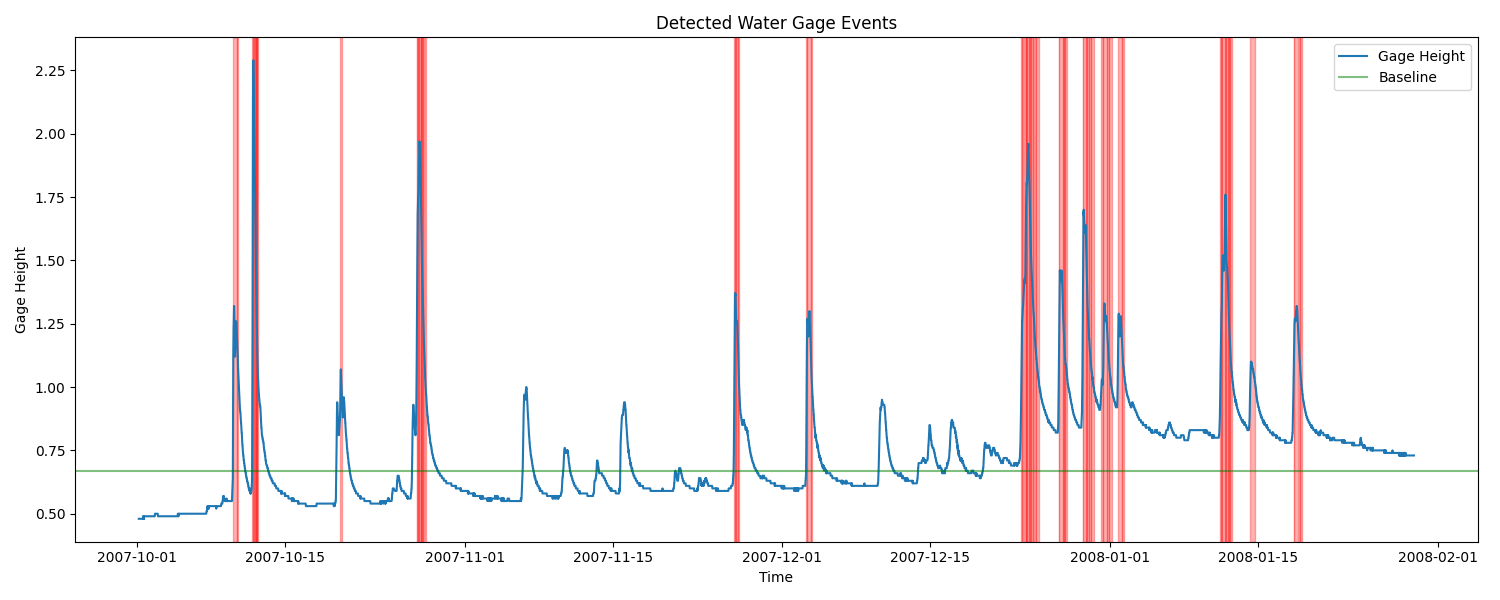

ValueError: too many values to unpack (expected 2)

In [104]:
def detect_events_with_ruptures(df, column_name='gage_height', date_column='datetime', model="rbf", pen=10):

    # Convert datetime column to pandas datetime if needed
    if date_column in df.columns:
        df[date_column] = pd.to_datetime(df[date_column])

    # Extract signal
    signal = df[column_name].values

    # Apply change point detection
    # model = "rbf"  # Radial Basis Function cost model
    algo = rpt.Pelt(model=model).fit(signal)
    change_points = algo.predict(pen=pen)

    # Process segments to identify events
    events = []
    baseline = np.median(signal)  # Use median as reference for normal state

    for i in range(len(change_points)-1):
        start_idx = change_points[i]
        end_idx = change_points[i+1] - 1

        segment = signal[start_idx:end_idx]
        segment_mean = np.mean(segment)
        segment_std = np.std(segment)

        # Determine if segment is an event using statistical properties
        # An event typically has higher mean and/or variance compared to baseline
        z_score = abs((segment_mean - baseline) / np.std(signal))

        # If this segment represents an event (z-score indicates abnormal behavior)
        if z_score > 1.5 or segment_std > 1.5 * np.std(signal):
            # Fine-tuning the exact start/end within the change point window
            # Look for when the signal starts deviating significantly from baseline
            fine_start = start_idx
            for j in range(start_idx, min(start_idx + 20, end_idx)):
                if abs(signal[j] - baseline) > 0.5 * abs(segment_mean - baseline):
                    fine_start = j
                    break

            # Look for when the signal returns to normal
            fine_end = end_idx
            for j in range(end_idx, max(end_idx - 20, start_idx), -1):
                if abs(signal[j] - baseline) > 0.5 * abs(segment_mean - baseline):
                    fine_end = j
                    break

            # Create event record with precise timestamps
            events.append({
                'start_time': df[date_column].iloc[fine_start],
                'end_time': df[date_column].iloc[min(fine_end, len(df)-1)],
                'start_idx': fine_start,
                'end_idx': fine_end,
                'magnitude': segment_mean - baseline,
                'duration': (df[date_column].iloc[min(fine_end, len(df)-1)] -
                            df[date_column].iloc[fine_start]).total_seconds() / 3600  # hours
            })

    # Visualize the results
    plt.figure(figsize=(15, 6))
    plt.plot(df[date_column], signal, label='Gage Height')
    plt.axhline(y=baseline, color='g', linestyle='-', alpha=0.5, label='Baseline')

    # Highlight events
    for event in events:
        plt.axvspan(event['start_time'], event['end_time'],
                   color='r', alpha=0.3)

    plt.title('Detected Water Gage Events')
    plt.xlabel('Time')
    plt.ylabel('Gage Height')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return events

events = detect_events_with_ruptures(df, 'height', 'time', model="rbf", pen=2)

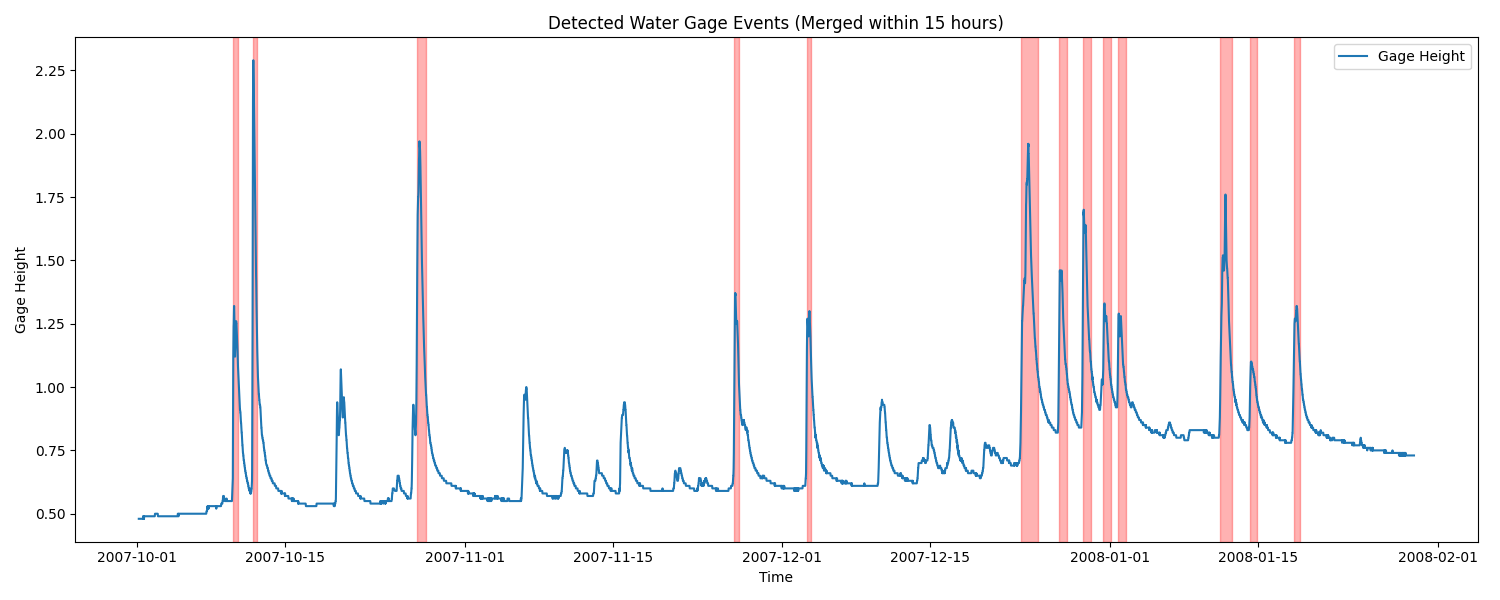

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ruptures as rpt
from scipy import stats
from datetime import timedelta

def detect_water_events_with_merging(df, column_name='gage_height', date_column='datetime', model="rbf", pen=10, merge_threshold_hours=24):

    # Convert datetime column to pandas datetime if needed
    if date_column in df.columns:
        df[date_column] = pd.to_datetime(df[date_column])

    # Extract signal
    signal = df[column_name].values

    # Apply change point detection
    model = "rbf"  # Radial Basis Function cost model
    algo = rpt.Pelt(model=model).fit(signal)
    change_points = algo.predict(pen=10)

    # Process segments to identify events
    events = []
    baseline = np.median(signal)  # Use median as reference for normal state

    for i in range(len(change_points)-1):
        start_idx = change_points[i]
        end_idx = change_points[i+1] - 1

        segment = signal[start_idx:end_idx]
        segment_mean = np.mean(segment)
        segment_std = np.std(segment)

        # Determine if segment is an event using statistical properties
        z_score = abs((segment_mean - baseline) / np.std(signal))

        # If this segment represents an event
        if z_score > 1.5 or segment_std > 1.5 * np.std(signal):
            # Fine-tune exact start/end
            fine_start = start_idx
            for j in range(start_idx, min(start_idx + 20, end_idx)):
                if abs(signal[j] - baseline) > 0.5 * abs(segment_mean - baseline):
                    fine_start = j
                    break

            fine_end = end_idx
            for j in range(end_idx, max(end_idx - 20, start_idx), -1):
                if abs(signal[j] - baseline) > 0.5 * abs(segment_mean - baseline):
                    fine_end = j
                    break

            # Create event record
            events.append({
                'start_time': df[date_column].iloc[fine_start],
                'end_time': df[date_column].iloc[min(fine_end, len(df)-1)],
                'start_idx': fine_start,
                'end_idx': fine_end,
                'magnitude': segment_mean - baseline,
                'duration': (df[date_column].iloc[min(fine_end, len(df)-1)] -
                            df[date_column].iloc[fine_start]).total_seconds() / 3600  # hours
            })

    # Merge events that are close together
    if len(events) > 1:
        merged_events = []
        current_event = events[0]

        for i in range(1, len(events)):
            next_event = events[i]

            # Calculate time between this event's end and next event's start
            time_diff = (next_event['start_time'] - current_event['end_time']).total_seconds() / 3600  # hours

            # If events are close enough, merge them
            if time_diff <= merge_threshold_hours:
                # Update current event to include the next event
                current_event['end_time'] = next_event['end_time']
                current_event['end_idx'] = next_event['end_idx']
                current_event['duration'] = (current_event['end_time'] -
                                           current_event['start_time']).total_seconds() / 3600

                # Recalculate magnitude for merged event
                event_signal = signal[current_event['start_idx']:current_event['end_idx']+1]
                current_event['magnitude'] = np.mean(event_signal) - baseline
            else:
                # Add the current event to our merged list and start a new current event
                merged_events.append(current_event)
                current_event = next_event

        # Don't forget to add the last event
        merged_events.append(current_event)
        events = merged_events

    # Visualize the results
    plt.figure(figsize=(15, 6))
    plt.plot(df[date_column], signal, label='Gage Height')
    # plt.axhline(y=baseline, color='g', linestyle='-', alpha=0.5, label='Baseline')

    # Highlight merged events
    for event in events:
        plt.axvspan(event['start_time'], event['end_time'],
                   color='r', alpha=0.3)

    plt.title(f'Detected Water Gage Events (Merged within {merge_threshold_hours} hours)')
    plt.xlabel('Time')
    plt.ylabel('Gage Height')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return events


events = detect_water_events_with_merging(df, 'height', 'time', model="rbf", pen=1, merge_threshold_hours=15)

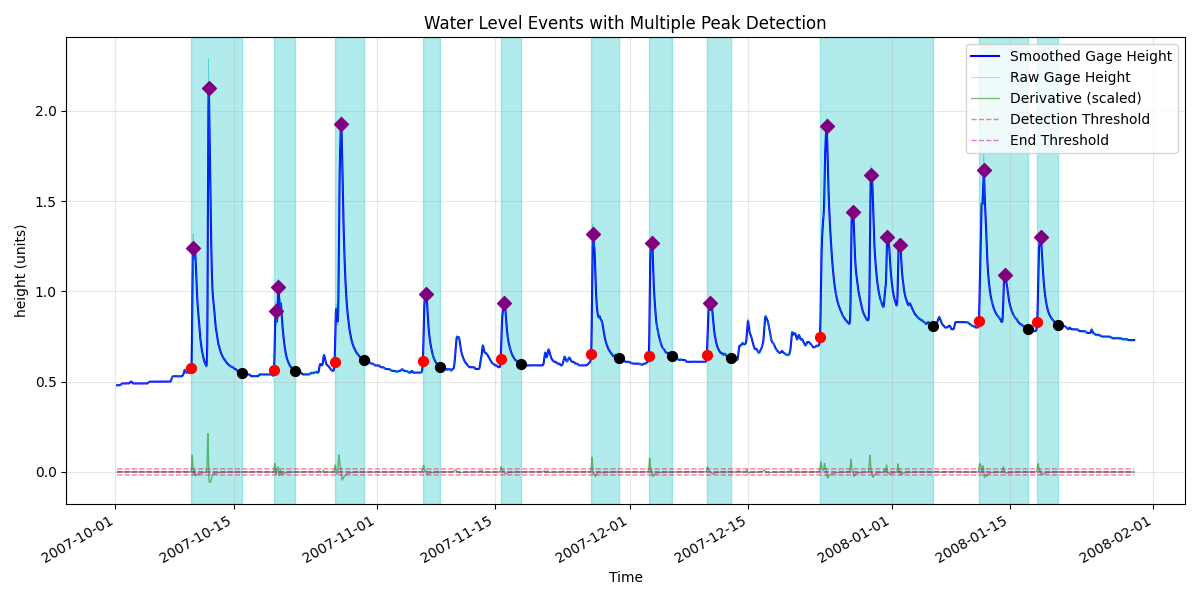

11


In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_prominences
from scipy import ndimage
from datetime import timedelta
import matplotlib.dates as mdates

def detect_events_phase_space(data, height_col='gage_height', time_col='datetime',
                             smoothing_window=24, detect_threshold=0.1,
                             end_threshold=0.05, min_duration=6,
                             merge_threshold=24, extension_window=48,
                             peak_height=None, peak_prominence=0.1, peak_distance=12):
    """
    Detect hydrological events using phase space analysis (derivative vs height)
    and display them on a time series plot, including multiple peak detection

    Parameters:
    -----------
    data : pandas DataFrame
        DataFrame containing the gage height time series
    height_col : str
        Column name for gage height data
    time_col : str
        Column name for datetime data
    smoothing_window : int
        Window size for smoothing the data (in hours)
    detect_threshold : float
        Threshold for derivative to be considered significant for event detection
    end_threshold : float
        Lower threshold for derivative to determine when an event truly ends
    min_duration : int
        Minimum duration for an event in hours
    merge_threshold : int
        Time threshold (in hours) to merge nearby events
    extension_window : int
        Maximum number of time steps to look ahead for event ending
    peak_height : float or None
        Minimum height for a peak to be detected (None for automatic)
    peak_prominence : float
        Minimum prominence for a peak to be detected (relative to height range)
    peak_distance : int
        Minimum distance between peaks (in time steps)

    Returns:
    --------
    events : list of dicts
        List of event dictionaries containing start_time, end_time, and peaks
    """
    # Ensure data is sorted by time
    data = data.sort_values(by=time_col)

    # Convert to numeric if needed and handle missing values
    heights = pd.to_numeric(data[height_col], errors='coerce')
    heights = heights.interpolate()

    # Apply smoothing to reduce noise
    heights_smooth = ndimage.gaussian_filter1d(heights, sigma=smoothing_window/4)

    # Calculate derivative (rate of change)
    # Using simple difference with appropriate time scaling
    time_diff = np.diff(data[time_col].astype(np.int64)) / 1e9 / 3600  # Convert to hours
    height_diff = np.diff(heights_smooth)
    derivative = height_diff / time_diff

    # Add a 0 at the end to match length of original data
    derivative = np.append(derivative, 0)

    # Find where derivative exceeds detection threshold (both positive and negative)
    significant_changes = np.abs(derivative) > detect_threshold

    # Find contiguous regions of significant changes for initial event detection
    labeled_regions, num_regions = ndimage.label(significant_changes)

    # Extract initial events
    raw_events = []
    for i in range(1, num_regions + 1):
        event_indices = np.where(labeled_regions == i)[0]

        if len(event_indices) >= min_duration:  # Only keep events longer than min_duration
            start_idx = event_indices[0]
            init_end_idx = event_indices[-1]

            # Find the peak within this event
            event_segment = heights_smooth[start_idx:init_end_idx+1]
            peak_offset = np.argmax(event_segment)
            peak_idx = start_idx + peak_offset

            # Now look for the true end of the event
            # We'll search in a window after the peak, not after the initial end
            # This better captures the falling limb
            max_search_idx = min(peak_idx + extension_window, len(derivative) - 1)

            # Initialize with the initial end
            end_idx = init_end_idx

            # Track the minimum derivative value we find
            min_derivative = np.inf
            min_derivative_idx = end_idx

            # Method 1: Find where derivative crosses below end_threshold
            found_end = False
            for j in range(peak_idx + 1, max_search_idx):
                # Keep track of the smallest derivative we find
                if abs(derivative[j]) < min_derivative:
                    min_derivative = abs(derivative[j])
                    min_derivative_idx = j

                # If we find a point below end_threshold, use it
                if abs(derivative[j]) <= end_threshold:
                    end_idx = j
                    found_end = True
                    break

            # If we didn't find a point below end_threshold,
            # use the point with the smallest derivative
            if not found_end and min_derivative_idx > end_idx:
                end_idx = min_derivative_idx

            # Get actual timestamps
            start_time = data[time_col].iloc[start_idx]
            end_time = data[time_col].iloc[end_idx]

            raw_events.append({
                'start_time': start_time,
                'end_time': end_time,
                'start_idx': start_idx,
                'end_idx': end_idx
            })

    # Merge events that are too close to each other
    if not raw_events:
        events = []
    else:
        # Sort events by start time
        raw_events.sort(key=lambda x: x['start_time'])

        # Initialize merged events with the first event
        events = [raw_events[0]]

        # Merge subsequent events if they're close enough
        for current_event in raw_events[1:]:
            prev_event = events[-1]

            # Calculate time difference between previous event end and current event start
            time_between = (current_event['start_time'] - prev_event['end_time']).total_seconds() / 3600  # in hours

            if time_between <= merge_threshold:
                # Merge with previous event
                events[-1]['end_time'] = max(current_event['end_time'], prev_event['end_time'])
                events[-1]['end_idx'] = max(current_event['end_idx'], prev_event['end_idx'])
            else:
                # Add as a new event
                events.append(current_event)

    # Detect peaks within each event
    for event in events:
        start_idx = event['start_idx']
        end_idx = event['end_idx']

        # Extract event segment
        event_data = heights_smooth[start_idx:end_idx+1]

        # Calculate peak parameters
        height_range = np.max(event_data) - np.min(event_data)
        min_prominence = peak_prominence * height_range

        if peak_height is None:
            # Set peak_height to a percentage of the range if not specified
            min_height = np.min(event_data) + 0.5 * height_range
        else:
            min_height = peak_height

        # Find all peaks in the event
        peaks, peak_properties = find_peaks(
            event_data,
            height=min_height,
            distance=peak_distance,
            prominence=min_prominence
        )

        # Convert peak indices to data indices
        event_peaks = [start_idx + peak_idx for peak_idx in peaks]

        # Store peak times and heights
        peak_times = [data[time_col].iloc[idx] for idx in event_peaks]
        peak_heights = [heights_smooth[idx] for idx in event_peaks]

        # Calculate prominences
        if len(peaks) > 0:
            prominences = peak_prominences(event_data, peaks)[0]
        else:
            prominences = []

        # Store peak information in the event
        event['peaks'] = [{
            'time': time,
            'height': height,
            'prominence': prom,
            'index': idx
        } for time, height, prom, idx in zip(peak_times, peak_heights, prominences, event_peaks)]

    # Create a time series plot with highlighted events
    plt.figure(figsize=(12, 6))

    # Plot height vs time
    plt.plot(data[time_col], heights_smooth, 'b-', linewidth=1.5, label='Smoothed Gage Height')
    plt.plot(data[time_col], heights, 'c-', alpha=0.5, linewidth=0.5, label='Raw Gage Height')

    # Plot derivative (scaled) to show threshold levels
    max_height = heights_smooth.max()
    scaled_derivative = derivative * (max_height / derivative.max() / 10)
    plt.plot(data[time_col], scaled_derivative, 'g-', alpha=0.5, linewidth=1, label='Derivative (scaled)')

    # Add threshold reference lines
    detect_line = np.ones_like(heights_smooth) * (detect_threshold * max_height / derivative.max() / 10)
    end_line = np.ones_like(heights_smooth) * (end_threshold * max_height / derivative.max() / 10)
    plt.plot(data[time_col], detect_line, 'r--', alpha=0.5, linewidth=1, label='Detection Threshold')
    plt.plot(data[time_col], -detect_line, 'r--', alpha=0.5, linewidth=1)
    plt.plot(data[time_col], end_line, 'm--', alpha=0.5, linewidth=1, label='End Threshold')
    plt.plot(data[time_col], -end_line, 'm--', alpha=0.5, linewidth=1)

    # Highlight the events using axvspan
    # colors = ['#ffcccc', '#ccffcc', '#ccccff', '#ffffcc', '#ffccff', '#ccffff']  # Different colors for events

    for idx, event in enumerate(events):
        # color = colors[idx % len(colors)]  # Cycle through colors for different events
        plt.axvspan(event['start_time'], event['end_time'], alpha=0.3, color='c',
                   label=f'Event {idx+1}' if idx < 10 else None)  # Only show first 10 in legend

        # Mark start and end points
        start_idx = event['start_idx']
        end_idx = event['end_idx']

        start_height = heights_smooth[start_idx]
        end_height = heights_smooth[end_idx]

        plt.scatter(event['start_time'], start_height, color='red', s=50, zorder=5)
        plt.scatter(event['end_time'], end_height, color='black', s=50, zorder=5)

        # Mark detected peaks
        for peak in event['peaks']:
            plt.scatter(peak['time'], peak['height'], color='purple', s=50, marker='D', zorder=6)
            # Add peak label if there are multiple peaks
            # if len(event['peaks']) > 1:
            #     plt.text(peak['time'], peak['height'] + 0.02 * max_height,
            #              f"P{event['peaks'].index(peak)+1}",
            #              ha='center', va='bottom')

    # Format the x-axis to show dates nicely
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()  # Rotate date labels

    plt.xlabel('Time')
    plt.ylabel(f'{height_col} (units)')
    plt.title('Water Level Events with Multiple Peak Detection')
    plt.grid(True, alpha=0.3)

    # Add a legend but keep it manageable
    if len(events) > 5:
        handles, labels = plt.gca().get_legend_handles_labels()
        # Keep the first 5 handles/labels (data series) and remove event labels
        plt.legend(handles[:5], labels[:5])
    else:
        plt.legend()

    plt.tight_layout()
    plt.savefig('water_level_events_with_peaks.png')
    plt.show()

    return events

df = pd.read_csv('usgs-data/01302020_shorter2.csv') # read in data
df = df.rename(columns={'00065': 'height', 'datetime': 'time'}) # rename columns

df['time'] = pd.to_datetime(df['time'], format="%Y-%m-%d %H:%M:%S%z") # convert time from strings to datetime

events = detect_events_phase_space(df, 'height', 'time', smoothing_window=18, detect_threshold=0.04, end_threshold=1e-5, min_duration=1,
                                   merge_threshold=8, extension_window=500, peak_height=0.8, peak_prominence=0.1, peak_distance=3)

print(len(events))